# Evaluating a trained link predictor on unseen triples

In this notebook we take a model for link prediction, and test it over a set of triples containing unseen entities.

In [1]:
import os.path as osp

import matplotlib.pyplot as plt
import pandas as pd
from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import torch
from tqdm import tqdm

Change this cell to generate a report for other datasets/models:

In [2]:
MODEL_ID = 'cttc3ucm'

## Loading model and data

In [3]:
base_path = osp.join('..', 'models', MODEL_ID)
model_path = osp.join(base_path, 'trained_model.pkl')
model = torch.load(model_path)
train = TriplesFactory.from_path_binary(osp.join(base_path, 'training_triples'))

graph_path = osp.join('..', 'data', 'biokgb', 'graph')
valid_triples = 'biokg.links-valid.csv'
test_triples = 'biokg.links-test.csv'

valid, test = [TriplesFactory.from_path(osp.join(graph_path, f),
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (valid_triples, test_triples)]

In [4]:
protein_data = torch.load('../data/biokgb/properties/protein_prottrans_embeddings_24_12.pt')
print(protein_data.keys())

dict_keys(['embeddings', 'identifiers'])


In [5]:
inductive_triples = pd.read_csv('../data/biokgb/graph/inductive-triples-from-benchmarks-15-03-2023.csv',
                                delimiter=',', usecols=[0, 1, 2], names=['head', 'rel', 'tail'])

For now we will select only PPI relations:

In [6]:
inductive_triples = inductive_triples[inductive_triples['rel'] == 'PPI']

In [7]:
from functools import partial

def not_in_set(row, entity_set):
    if row['head'] not in entity_set and row['tail'] not in entity_set:
        return 'both'
    elif row['head'] not in entity_set:
        return 'head'
    elif row['tail'] not in entity_set:
        return 'tail'
    else:
        return 'none'

inductive_triples['inductive'] = inductive_triples.apply(partial(not_in_set, entity_set=train.entity_to_id), axis=1)
inductive_triples['inductive'].value_counts()

tail    1250
head      44
both       3
Name: inductive, dtype: int64

In [8]:
inductive_triples['missing-embedding'] = inductive_triples.apply(partial(not_in_set, entity_set=protein_data['identifiers']), axis=1)
inductive_triples['missing-embedding'].value_counts()

none    1295
tail       2
Name: missing-embedding, dtype: int64

There are some triples with entities for which we don't have an embedding:

In [9]:
inductive_triples[inductive_triples['missing-embedding'] != 'none']

,head,rel,tail,inductive,missing-embedding
139503,Q8N4C8,PPI,Q5SRD0,tail,tail
139689,Q07912,PPI,Q5SRD0,tail,tail


For now we will drop them:

In [10]:
inductive_triples = inductive_triples[inductive_triples['missing-embedding'] == 'none']

## Detect unseen entities in the new set of triples

In [11]:
inductive_triples_entities = set(inductive_triples[['head', 'tail']].stack().tolist())
unseen_entities = inductive_triples_entities.difference(train.entity_to_id)
print(f'There are {len(unseen_entities)} unseen entities')

There are 270 unseen entities


## Registering new entities

### In a new mapping from entity to ID

In [12]:
updated_entity_to_id = train.entity_to_id.copy()
embeddings = []
new_entity_ids = []
for new_entity in unseen_entities:
    updated_entity_to_id[new_entity] = len(updated_entity_to_id)
    embeddings.append(protein_data['embeddings'][protein_data['identifiers'][new_entity]])
    new_entity_ids.append(updated_entity_to_id[new_entity])

embeddings = torch.stack(embeddings)
len(train.entity_to_id), len(updated_entity_to_id), embeddings.shape

(106047, 106317, torch.Size([270, 1024]))

### In the model

Steps for updating the model:

- Extending the data structures containing type-specific data
- Extending the buffer
- Encoding the new entities and storing the result in the buffer

In [16]:
for type_id, encoder in model.property_encoder.type_id_to_encoder.items():
    print(type_id, encoder.__class__)

0 <class 'bioblp.models.encoders.PretrainedLookupTableEncoder'>


## Evaluation

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluator = RankBasedEvaluator(filtered=True)
results = evaluator.evaluate(model, test.mapped_triples,
                             additional_filter_triples=[train.mapped_triples,
                                                        valid.mapped_triples])

Evaluating on cuda:0:   0%|          | 0.00/185k [00:00<?, ?triple/s]

In [12]:
results.get_metric('both.realistic.hits_at_1')

0.44461120678950694

---

### Evaluating on the original splits

In [4]:
train, valid, test = load_triples_factories(DATA_PATH, DATASET)

In [5]:
evaluator = RankBasedEvaluator()
results_all_rels = evaluator.evaluate(model, valid.mapped_triples)

Evaluating on cuda:   0%|          | 0.00/61.2k [00:00<?, ?triple/s]

In [6]:
def make_results_dict(results, relation, relation_count):
    results_dict = {'Relation': 'All' if not relation else relation,
                    'Count': relation_count,
                    'adjusted_mean_rank': results.adjusted_mean_rank['both'],
                    'mean_rank': results.mean_rank['both']['avg'],
                    'mean_reciprocal_rank': results.mean_reciprocal_rank['both']['avg'],
                    **{f'hits_at_{k}': hits for k, hits in results.hits_at_k['both']['avg'].items()}}

    return results_dict

In [7]:
results_all_rels_dict = make_results_dict(results_all_rels, relation='All', relation_count=valid.num_triples)
results_all_rels_dict

{'Relation': 'All',
 'Count': 61185,
 'adjusted_mean_rank': 0.05457443148959907,
 'mean_rank': 4799.454968538041,
 'mean_reciprocal_rank': 0.20134694073780043,
 'hits_at_1': 0.1279643703522105,
 'hits_at_3': 0.2206586581678516,
 'hits_at_5': 0.2709079022636267,
 'hits_at_10': 0.3530195309307837}

### Evaluating over specific relation types

In [8]:
result_dicts = []
for relation in tqdm(model.triples_factory.relation_to_id, desc='Evaluating over each relation'):
    triples_subset = valid.new_with_restriction(relations=[relation])
    if triples_subset.num_triples > 0:
        subset_result = evaluator.evaluate(model, triples_subset.mapped_triples, use_tqdm=False)
        result_dicts.append({'results': subset_result, 'relation': relation, 'count': triples_subset.num_triples})

Evaluating over each relation: 100%|██████████| 18/18 [04:02<00:00, 13.48s/it]


In [9]:
results_df = pd.DataFrame([make_results_dict(d['results'], d['relation'], d['count']) for d in result_dicts])
results_df

,Relation,Count,adjusted_mean_rank,mean_rank,mean_reciprocal_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,Binding_Protein_Protein,25448,0.020872,1838.891121,0.130362,0.050318,0.126022,0.187991,0.309042
1,Binding_Protein_SmallMol,12718,0.069629,6116.564869,0.375663,0.294936,0.431632,0.467762,0.514625
2,Binding_SmallMol_Protein,13388,0.067184,5901.834889,0.292672,0.199694,0.336869,0.404616,0.489468
3,ChemicalReaction_Protein_SmallMol,18,0.089389,7879.222222,0.002090,0.000000,0.000000,0.000000,0.000000
4,DirectRegulation_Protein_Protein,1073,0.046661,4113.163094,0.006139,0.000000,0.002796,0.006524,0.010718
5,DirectRegulation_SmallMol_Protein,7869,0.119330,10503.774272,0.036829,0.015567,0.036218,0.052040,0.077519
6,MolSynthesis_SmallMol_SmallMol,231,0.051740,4558.804113,0.013678,0.004329,0.008658,0.010823,0.019481
7,MolTransport_SmallMol_SmallMol,440,0.046223,4072.227273,0.014495,0.002273,0.010227,0.014773,0.025000


In [10]:
restricted_rels_macro_performance = results_df[results_df.columns[2:]].mean(axis=0)
restricted_rels_macro_performance

adjusted_mean_rank         0.063879
mean_rank               5623.060232
mean_reciprocal_rank       0.108991
hits_at_1                  0.070890
hits_at_3                  0.119053
hits_at_5                  0.143066
hits_at_10                 0.180732
dtype: float64

Note that this is **not** the same as the original, unrestricted evaluation. When restricting by relation, the average above is a *macro-average*, where all relations are weighted equally. In the unrestricted scenario, we average over all triples, which is a *micro-average* where more frequent relations are weighted higher:

In [11]:
results_all_rels_dict

{'Relation': 'All',
 'Count': 61185,
 'adjusted_mean_rank': 0.05457443148959907,
 'mean_rank': 4799.454968538041,
 'mean_reciprocal_rank': 0.20134694073780043,
 'hits_at_1': 0.1279643703522105,
 'hits_at_3': 0.2206586581678516,
 'hits_at_5': 0.2709079022636267,
 'hits_at_10': 0.3530195309307837}

Since we have the triple counts for each relation, we can compute a micro-average instead:

In [12]:
restricted_rels_micro_performance = results_df[results_df.columns[2:]].mul(results_df['Count'], axis=0).sum(axis=0) / results_df['Count'].sum()
restricted_rels_micro_performance

adjusted_mean_rank         0.054574
mean_rank               4799.454969
mean_reciprocal_rank       0.201347
hits_at_1                  0.127964
hits_at_3                  0.220659
hits_at_5                  0.270908
hits_at_10                 0.353020
dtype: float64

How do MRR, H@k, and AMR correlate?

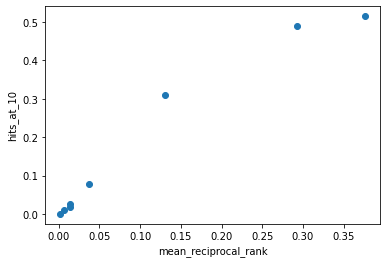

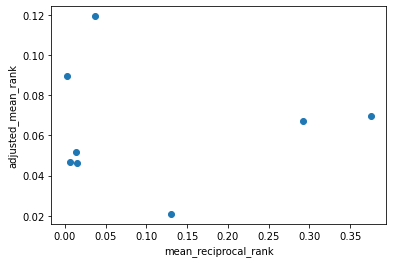

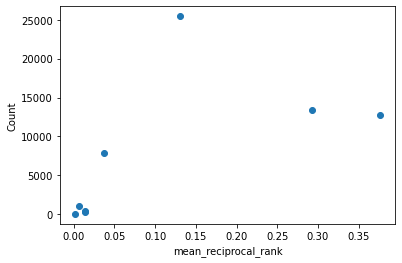

In [13]:
def plot_metric_pair(results_df, metric_1: str, metric_2: str):
    """Make a scatter plot with one link prediction metric in each axis."""
    plt.figure()
    plt.scatter(results_df[metric_1], results_df[metric_2])
    plt.xlabel(metric_1)
    plt.ylabel(metric_2)

plot_metric_pair(results_df, 'mean_reciprocal_rank', 'hits_at_10')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'adjusted_mean_rank')
plot_metric_pair(results_df, 'mean_reciprocal_rank', 'Count')

What are the relations where the model performs better?

In [14]:
def per_relation_plot(results_df, metric: str):
    """Make a bar plot of link prediction performance for each relation."""
    results_df[['Relation', metric]].sort_values(by=metric).plot.barh(x='Relation', figsize=(5, 5), grid=True)

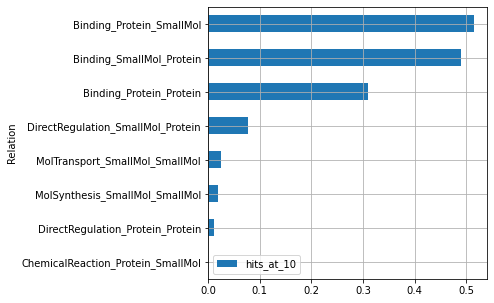

In [15]:
per_relation_plot(results_df, 'hits_at_10')

### Evaluating over specific entity and relation types

The source csv files contain the triples, plus extra information like the types of the entities involved in the triple. We will extract the type information.

In [16]:
train_df = pd.read_csv(osp.join(DATA_PATH, f'processed/{DATASET}-train.tsv'), sep='\t', dtype=str)
train_df.head()

,src,edg,tgt,directed,effect,mechanism,pubyear,refcount,src_type,tgt_type,allowed_triple
0,72057594037932965,Binding_Protein_SmallMol,72057594038977157,False,NaN,NaN,20142014,1,Protein,SmallMol,1
1,72057594038337047,Binding_SmallMol_Protein,72057594037929179,False,NaN,NaN,20142014,1,SmallMol,Protein,1
2,72057594038337047,Binding_SmallMol_Protein,72057594037929189,False,NaN,NaN,20142014,1,SmallMol,Protein,1
3,72057594038397248,DirectRegulation_SmallMol_Protein,72057594037932320,True,positive,direct interaction,20142014,1,SmallMol,Protein,1
4,72057594038417091,DirectRegulation_SmallMol_Protein,72057594037932320,True,positive,direct interaction,20142014,1,SmallMol,Protein,1


In [17]:
def get_types_to_entities_dict(df):
    """Given a dataframe of triples, containing types for entities at the
    head and tail, extract a dictionary mapping entity types (str) to
    a list of entities of that type."""
    src_df = df[['src', 'src_type']]
    tgt_df = df[['tgt', 'tgt_type']]

    src_df = src_df.rename(columns={'src': 'entity', 'src_type': 'type'})
    tgt_df = tgt_df.rename(columns={'tgt': 'entity', 'tgt_type': 'type'})
    combined_df = pd.concat([src_df, tgt_df]).drop_duplicates(subset='entity')

    type_to_entities = combined_df.groupby('type')['entity'].apply(list).to_dict()

    return type_to_entities

In [18]:
type_to_entities = get_types_to_entities_dict(train_df)
for t, entities in type_to_entities.items():
    print(f'{t}: {len(entities):,} entities')

Disease: 3,213 entities
Protein: 17,256 entities
SmallMol: 155,841 entities


We can now get a list of e.g. Diseases with this dictionary:

In [19]:
type_to_entities['Disease'][:5]

['72057594038079067',
 '72057594038079958',
 '72057594038086754',
 '72057594038136174',
 '72057594038136215']

We can now run the evaluation by relation type, separately for heads and tails of a specific type:

In [20]:
def get_side_prediction_results(model, evaluator, mapped_triples, restrict_entities_to, side: str, relation: str):
        assert side in {'head', 'tail'}

        results = evaluator.evaluate(model, mapped_triples, restrict_entities_to=restrict_entities_to,
                                     do_time_consuming_checks=False, use_tqdm=False)
        results_df = results.to_df()
        results_df = results_df.loc[(results_df['Side'] == side) & (results_df['Type'] == 'avg')]

        results_dict = {'Relation': relation, 'Side': side}
        results_dict.update({metric: value for metric, value in zip(results_df['Metric'].values, results_df['Value'].values)})

        return results_dict

results = []
evaluator = RankBasedEvaluator()
for relation in tqdm(model.triples_factory.relation_to_id, desc='Evaluating over each relation'):
    relation_parts = relation.split('_')
    head_type, tail_type = relation_parts[-2:]

    # Create subsets based on entity and relation
    triples_subset = valid.new_with_restriction(relations=[relation])
    if triples_subset.num_triples == 0:
        continue

    head_entities = type_to_entities[head_type]
    tail_entities = type_to_entities[tail_type]
    head_ids = torch.tensor(train.entities_to_ids(head_entities), dtype=torch.long)
    tail_ids = torch.tensor(train.entities_to_ids(tail_entities), dtype=torch.long)

    head_prediction_results = get_side_prediction_results(model, evaluator, triples_subset.mapped_triples, restrict_entities_to=head_ids, side='head', relation=relation)
    tail_prediction_results = get_side_prediction_results(model, evaluator, triples_subset.mapped_triples, restrict_entities_to=tail_ids, side='tail', relation=relation)
    results.extend([head_prediction_results, tail_prediction_results])

Evaluating over each relation:   6%|▌         | 1/18 [03:14<55:06, 194.47s/it]/home/jovyan/discovery-LP/.venv-bio-blp/lib/python3.8/site-packages/pykeen/evaluation/rank_based_evaluator.py:307: RuntimeWarning: divide by zero encountered in reciprocal
  mean_reciprocal_rank[side][rank_type] = np.mean(np.reciprocal(ranks))
Evaluating over each relation: 100%|██████████| 18/18 [08:05<00:00, 27.00s/it]


In [21]:
entity_restrict_results_df = pd.DataFrame(results)
entity_restrict_results_df

,Relation,Side,adjusted_mean_rank,mean_rank,mean_reciprocal_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,Binding_Protein_Protein,head,0.096103,823.215164,0.168035,0.076077,0.173412,0.247642,0.375904
1,Binding_Protein_Protein,tail,0.097644,836.321224,0.096266,0.027232,0.084093,0.134117,0.246817
2,Binding_Protein_SmallMol,head,0.122177,1048.564751,0.495991,0.436940,0.539943,0.560544,0.585155
3,Binding_Protein_SmallMol,tail,0.107362,8322.631624,0.272121,0.172983,0.337789,0.384573,0.454867
4,Binding_SmallMol_Protein,head,0.103356,8012.123394,0.295098,0.190320,0.356812,0.430908,0.510457
5,Binding_SmallMol_Protein,tail,0.119411,1024.605393,0.310601,0.230953,0.336645,0.395354,0.482298
6,ChemicalReaction_Protein_SmallMol,head,0.367477,3157.944444,0.000886,0.000000,0.000000,0.000000,0.000000
7,ChemicalReaction_Protein_SmallMol,tail,0.111259,8668.944444,0.003782,0.000000,0.000000,0.000000,0.000000
8,DirectRegulation_Protein_Protein,head,0.342272,2949.403541,0.006076,0.000000,0.003728,0.005592,0.009320
9,DirectRegulation_Protein_Protein,tail,0.284169,2450.669152,0.006258,0.000000,0.001864,0.007456,0.012116


We can check the performance when predicting separately the head and the tail, for each relation.

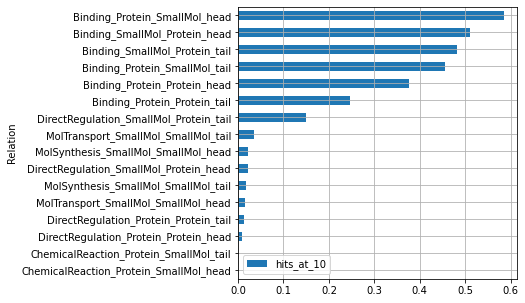

In [22]:
results_df_side_labeled = entity_restrict_results_df.copy()
results_df_side_labeled['Relation'] = results_df_side_labeled['Relation'] + '_' + results_df_side_labeled['Side']
per_relation_plot(results_df_side_labeled, 'hits_at_10')

We then average the prediction for the head and the tail:

In [23]:
results_both_df = entity_restrict_results_df.groupby('Relation')[entity_restrict_results_df.columns[2:]].mean().reset_index()
results_both_df

,Relation,adjusted_mean_rank,mean_rank,mean_reciprocal_rank,hits_at_1,hits_at_3,hits_at_5,hits_at_10
0,Binding_Protein_Protein,0.096874,829.768194,0.132150,0.051654,0.128753,0.190879,0.311360
1,Binding_Protein_SmallMol,0.114770,4685.598188,0.384056,0.304961,0.438866,0.472559,0.520011
2,Binding_SmallMol_Protein,0.111383,4518.364393,0.302849,0.210636,0.346728,0.413131,0.496377
3,ChemicalReaction_Protein_SmallMol,0.239368,5913.444444,0.002334,0.000000,0.000000,0.000000,0.000000
4,DirectRegulation_Protein_Protein,0.313220,2700.036347,0.006167,0.000000,0.002796,0.006524,0.010718
5,DirectRegulation_SmallMol_Protein,0.207197,8128.370663,0.040586,0.017283,0.040729,0.058076,0.085081
6,MolSynthesis_SmallMol_SmallMol,0.047698,3714.282468,0.015147,0.006494,0.008658,0.010823,0.019481
7,MolTransport_SmallMol_SmallMol,0.042364,3298.485795,0.014875,0.002273,0.010227,0.014773,0.025000


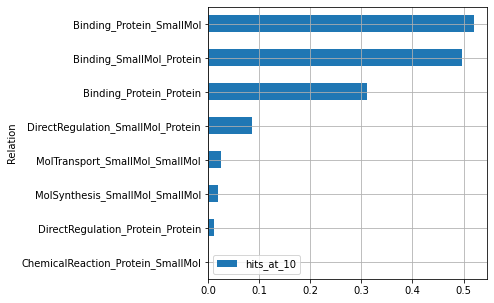

In [24]:
per_relation_plot(results_both_df, 'hits_at_10')

Lastly, the overall average is computed over all metrics.

In [25]:
results_both_df.mean()

adjusted_mean_rank         0.146609
mean_rank               4223.543812
mean_reciprocal_rank       0.112271
hits_at_1                  0.074163
hits_at_3                  0.122095
hits_at_5                  0.145846
hits_at_10                 0.183503
dtype: float64

Compare with the results when restricting by relation type only:

In [26]:
restricted_rels_macro_performance

adjusted_mean_rank         0.063879
mean_rank               5623.060232
mean_reciprocal_rank       0.108991
hits_at_1                  0.070890
hits_at_3                  0.119053
hits_at_5                  0.143066
hits_at_10                 0.180732
dtype: float64

Note that this is **not** the same as the original averages computed without restrictions:

In [27]:
restricted_rels_micro_performance

adjusted_mean_rank         0.054574
mean_rank               4799.454969
mean_reciprocal_rank       0.201347
hits_at_1                  0.127964
hits_at_3                  0.220659
hits_at_5                  0.270908
hits_at_10                 0.353020
dtype: float64

The micro-average is instead the following:

In [28]:
results_both_df[results_both_df.columns[2:]].mul(results_df['Count'], axis=0).sum(axis=0) / results_df['Count'].sum()

mean_rank               3439.965743
mean_reciprocal_rank       0.206554
hits_at_1                  0.133227
hits_at_3                  0.226036
hits_at_5                  0.275746
hits_at_10                 0.357588
dtype: float64

We can see that restricting predictions over the correct domain and range of a relation only slightly increases the results.